In [1]:
import asyncio
import time
import math
import numpy as np
from cv2 import VideoCapture
import matplotlib.pyplot as plt
from matplotlib import colors
import Global
# from vision.module import detection, utils, constants
# from vision.functions import vision_init, get_thymio
from vision.functions import vision_init, get_thymio
# import vision_nav
import KF
from Control import Control
import cv2
from itertools import chain
import math
import MotionControl


In [2]:
#Connecting to the tymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())

Node 459c102c-e51f-4d84-ba38-ef5cd6b70951

In [3]:
thymio = Control(node,client)

init


In [4]:
# aw(node.unlock())

In [5]:
#thymio.set_motors(0,"forward")

In [6]:
# ls,rs,prox = await thymio.get_sensors()
# display(ls)
# display(rs)
# display(prox)

In [7]:
# lock the camera resource
cap = VideoCapture(1)

In [25]:
grid = None
obs = []
obs_grid = None
targets = []
goal = []

# import constants
from vision.constants import grid_height_cells, grid_width_cells

In [26]:
#  vision initialization

flag, grid, obs, obs_grid, targets, goal = vision_init(cap)
print(obs_grid)

if not flag:
    assert 0

print(goal)
# if you get to this point, the vision is initialized and you have acquired information about the environment

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[3, 1]]


In [27]:
#Extracting targets to be in array and not matrix
targets = tuple([item for sublist in targets for item in sublist])


In [28]:
#Extracting goal to be in array and not matrix format
goal = tuple([item for sublist in goal for item in sublist])

In [29]:
display(goal)

(3, 1)

In [13]:
# !python -m pip install tk-tools

In [30]:
def create_empty_plot(width, height):
    
        fig, ax = plt.subplots(figsize=(width, height))

        major_ticks_x = np.arange(0, width+1, 5)
        minor_ticks_x = np.arange(0, width+1, 1)
        major_ticks_y = np.arange(0, height+1, 5)
        minor_ticks_y = np.arange(0, height+1, 1)

        ax.set_xticks(major_ticks_x)
        ax.set_xticks(minor_ticks_x, minor=True)
        ax.set_yticks(major_ticks_y)
        ax.set_yticks(minor_ticks_y, minor=True)
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

        ax.set_ylim([-1, height])
        ax.set_xlim([-1, width])
        ax.grid(True)

        return fig, ax

Text(0.5, 1.0, 'Map : free cells in white, occupied cells in red')

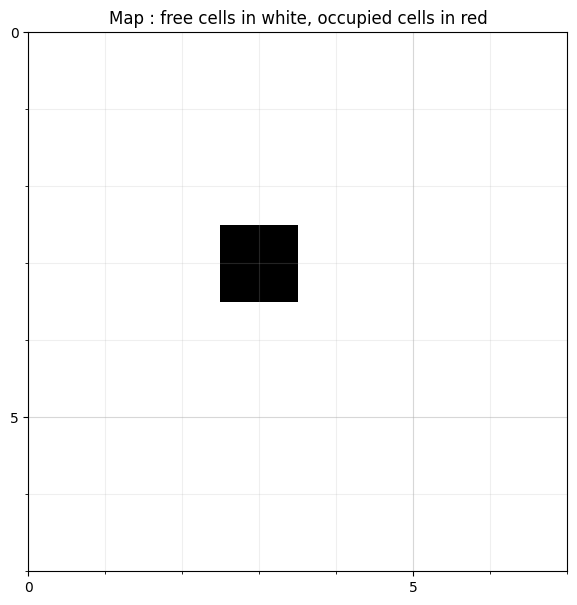

In [31]:
width = 7
height = 7
fig, ax = create_empty_plot(width,height)

# set plot origin to top left 
plt.xlim(0, width)
plt.ylim(height, 0)

# Displaying the map
cmap = colors.ListedColormap(['white', 'black'])
ax.imshow(obs_grid, cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red")

In [32]:
# List of all coordinates in the grid
#max_val is the size of the map
#x: 2D array where each element x[i, j] represents the x coordinate at position (i, j) in the grid.
#Donc x[1,n] rendra toujours 1 car la coord x d'un point en (1,n) est 1
#y: 2D array where each element y[i, j] represents the y coordinate at position (i, j) in the grid.
# List of all coordinates in the grid
x, y = np.mgrid[0:width:1, 0:height:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0] * x.shape[1], 2))

# Coords contains all the possible coordinates of the grid from (0,0) to (width-1, height-1)
coords = list([(int(x[1]), int(x[0])) for x in pos])

#Defining the start  point and end goal for now on
flag, t ,state = get_thymio(cap)
if flag:
    # start = tuple([state[0],state[1]]) # state[1]-0.5
    start = [state[0],state[1]]
    angle = state[2]
else:
    print("Problem with thymio_get function")
# start = tuple(map(np.floor,int(start)))
start = tuple({int(x) for x in start})

In [33]:
start

(3, 5)

In [34]:
#Defining the distance to the goal ignoring the obstacles, here using the Euclidian distance with the function np.linalg.norm
# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

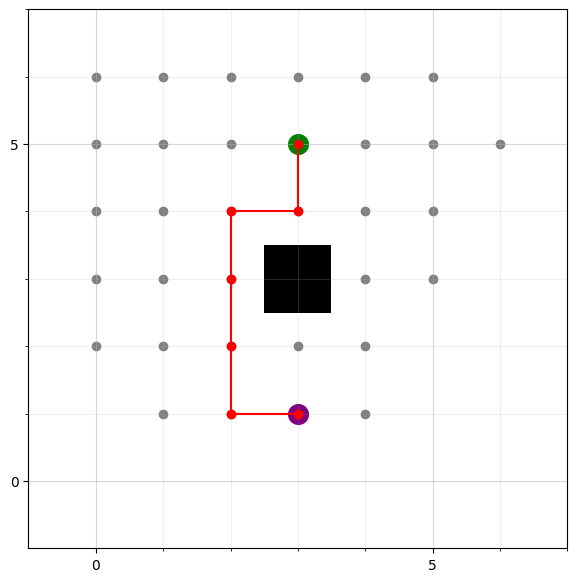

In [35]:
# Run the A* algorithm
path, visitedNodes = Global.A_Star(start, goal, h, coords, obs_grid, movement_type="4N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(width, height)  # Use width and height here
ax_astar.imshow(obs_grid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color='grey')
ax_astar.plot(path[0], path[1], marker="o", color='red')
ax_astar.scatter(start[0], start[1], marker="o", color='green', s=200)
ax_astar.scatter(goal[0], goal[1], marker="o", color='purple', s=200)


In [36]:
print(path)



[[3 3 2 2 2 2 3]
 [5 4 4 3 2 1 1]]


In [37]:
#Checking the state of camera
camera_on = True
flag, _, state = get_thymio(cap)
if not flag:
    print("Problem with vision_nav function")
    camera_on = False
else:
    pos = tuple([state[0],state[1]])
    print("The position given by vision is:",pos)
    angle = state[2]

print(angle)

The position given by vision is: (3.5, 5.66)
-92.9


In [38]:
from Control import Control
#Main 
index = 1
size_path = len(path[0])
old_pos = start
target = tuple(path[:,1])
epsilon = 0.2
Kidnapping_threshold = 4
arrived = False
sensor_scale = 200

# PID 
integral = 0.0
previous_error = 0.0
nearest_point_idx = 0
# PID 

while size_path > index: 
    
    #Checking the state of camera
    camera_on = True
    flag, _, state = get_thymio(cap)
    if not flag:
        print("Problem with vision_nav function")
        camera_on = False
    else:
        pos = tuple([state[0],state[1]])
        # print("The position given by vision is:",pos)
        angle = state[2]

    #Motor speed
    speed_left, speed_right, prox = await thymio.get_sensors()
    speed = [speed_left,speed_right]
    # print(speed)
    # print(camera_on)
    
    if camera_on == False:
        #Kalmann
        tracker = KF.KalmanFilter()
        speed_xy,orientation_est = tracker.compute_x_y_speed(speed[0],speed[1])
        print(pos)
        x_est = [pos[0],pos[1],speed_xy[0],speed_xy[1]]
        P_est = np.eye(4)*1000
        pos,speed,angle,x_est,P_est = tracker.predict(speed[0],speed[1],orientation_est,x_est,P_est)
        
    #calculer la norm old pos vs pos --> si superieur a treshold kidnapping
    distance = math.sqrt((pos[0] - old_pos[0])**2 + (pos[1] - old_pos[1])**2)
    if distance > Kidnapping_threshold:
        #Need to initialize kidnapping_threshold with a value
        #recompute vision to get the new position-> this new position is the new start point, the goal remain unchanged
        flag, _, state = get_thymio(cap)
        if flag:
            pos = tuple([state[0]-0.5,state[1]])
            angle = state[2]
        else:
            print("Problem with thymio_get function")
        path, visitedNodes = Global.A_Star(start, goal, h, coords, obs_grid, movement_type="4N")
        path = np.array(path).reshape(-1, 2).transpose()
        visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
        index = 0 #The index need to be re-initialized since we have a new path

    #Check if robot has arrived at target, and update it if ye


    # #start leds and sound

    #Function obstacle check to implement
    obstacle_detected = False
    #Need to add obstacle avoidance
 
    #Motion control
    print("thymio position:", pos)
    print("thymio angle:", angle)
    print("target", target)

    # left_speed, right_speed, _ = await thymio.get_sensors()
    vector_to_checkpoint = (target[0]+0.5 - pos[0], target[1]+0.5 - pos[1])
    
    target_angle = np.degrees(np.arctan2(vector_to_checkpoint[1],vector_to_checkpoint[0]))
    print(" Vector to checkpoint :", vector_to_checkpoint)
    print("target angle", target_angle)
    error = target_angle - angle
    #test_angle = np.degrees(np.arctan2(vector_to_checkpoint[1],vector_to_checkpoint[0]))+180
    updated_left_speed,updated_right_speed, integral,previous_error, turning = await(MotionControl.pid_controller(integral, error, previous_error))
    # print("The vector to check point : ",vector_to_checkpoint)
    # print("The angle computed before: ", error)
    print("Error : ", error)
    print("Turning: ", turning)
    while turning == True :
        thymio.set_motors_PID(updated_left_speed,updated_right_speed)
        await client.sleep(0.5)
        _,_,state = get_thymio(cap)
        error = target_angle - state[2]
        print(" ERROR EQUIV :", error)
        updated_left_speed,updated_right_speed, integral,previous_error, turning = await(MotionControl.pid_controller(integral, error, previous_error))

    thymio.set_motors_PID(60,60)
    await client.sleep(0.2)
    
    # print("closeness:", np.linalg.norm(path[:,idx]-np.array(pos)))
    # print("y difference:",np.abs(path[:,idx][1]-np.array(pos[1])))
    f1 = (np.abs((target[1]+0.5)-np.array(pos[1]) ) <= epsilon)
    f2 = (np.abs((target[0]+0.5)-np.array(pos[0]) ) <= epsilon)
    f3 = (index<size_path)
    print(f1, f2, f3)
    if f1 and f2 and f3:
        print("Prev index: ", index)
        if index == size_path-1:
            print("Arrived")
        else:
            target = tuple(path[:,index+1])
        index = index+1
        arrived = False
        print("new target is : ", target)
        print("INDEX IS ACTUALLY : ", index)
    # else:
    #     thymio.set_motors_PID(0,0)

    #start leds and sound
    
print("end")
thymio.set_motors_PID(0,0)

thymio position: (3.51, 5.66)
thymio angle: -92.31
target (3, 4)
 Vector to checkpoint : (-0.009999999999999787, -1.1600000000000001)
target angle -90.49391689861875
PID:  60.0 60.0
Error :  1.8160831013812526
Turning:  False
SETTING PID
False True True
thymio position: (3.5, 5.51)
thymio angle: -92.93
target (3, 4)
 Vector to checkpoint : (0.0, -1.0099999999999998)
target angle -90.0
PID:  60.0 60.0
Error :  2.930000000000007
Turning:  False
SETTING PID
False True True
thymio position: (3.5, 5.45)
thymio angle: -91.72
target (3, 4)
 Vector to checkpoint : (0.0, -0.9500000000000002)
target angle -90.0
PID:  60.0 60.0
Error :  1.7199999999999989
Turning:  False
SETTING PID
False True True
thymio position: (3.49, 5.39)
thymio angle: -93.43
target (3, 4)
 Vector to checkpoint : (0.009999999999999787, -0.8899999999999997)
target angle -89.35625428582465
PID:  59.0 61.0
Error :  4.0737457141753595
Turning:  False
SETTING PID
False True True
thymio position: (3.5, 5.32)
thymio angle: -93.48


In [23]:
v = {
    "motor.left.target": [0],
    "motor.right.target": [0],
}
aw(node.set_variables(v))


In [ ]:
# release the camera resource
cap.release()